In [1]:
# Import the required libraries.

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import numpy as np
import datetime as dt
import gmplot 
import os

In [2]:
# Read in the processed csv file created during data wrangling phase of project.

dataset=pd.read_csv('C:/Users/andre/Desktop/citibiki-wrangled-data.csv')

In [3]:
# Convert the 'starttime' and 'stoptime' columns to datetime format.

dataset['starttime'] = dataset.loc[:,'starttime'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))
dataset['stoptime'] = dataset.loc[:,'stoptime'].apply(lambda x:dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S.%f'))

In [4]:
#############################################################################################################################

In [5]:
# Station Volume Analysis Function.
#
# Input: df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
# 
# Output: volume - a data frame that contains the following columns:
#          
# 1. The identification number of the station ('station id').
# 2. Total number of "trip starts" that occured at each station ('ss volume').
# 3. Total number of "trip stops"  that occured at each station ('es volume').
# 4. Total number of "trip starts" and "trip stops" at each station ('total volume'= 'ss volume' + 'es volume').

def stationvolume(df):
    
    # Calculate the 'ss volume'.
    
    spoint = df['start station id'].value_counts()
    spoint=pd.DataFrame(spoint)
    spoint=spoint.reset_index()
    spoint.columns=['start station id', 'ss volume']

    # Calculate the 'es volume'.
    
    epoint = df['end station id'].value_counts()
    epoint=pd.DataFrame(epoint)
    epoint=epoint.reset_index()
    epoint.columns=['end station id', 'es volume']

    # Merge the 'ss volume' and 'es volume' data frames.
    
    volume=pd.merge(spoint,epoint, left_on='start station id', right_on='end station id')
    
    # Calculate the 'total volume' 
    
    volume['total volume']=volume['ss volume'] + volume['es volume']
        
    # Clean up the data frame and sort descending based on 'total volume'.
    
    volume=volume.sort_values('total volume', ascending=False)
    volume.rename(columns={'start station id':'station id'}, inplace=True)
    volume.reset_index(inplace=True)
    volume.drop('index', axis=1, inplace = True)
    volume.drop('end station id', axis=1, inplace = True)
    
    return(volume)


In [6]:
# Station Volume Mapping Function.  
#
# Input: 1. volume - the data frame generated by the "Station Volume Analysis Function".
#        2. df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        3. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the Citi Bike stations plotted on it. The 'total volume' 
#         percentile for each station is indciated as follows:  
#         -The 25th percentile stations are plotted as red circles.
#         -The stations bounded by the 25th to 75th percentile are plotted as yellow circles.
#         -The stations above the 75th percentile (top 25 stations for 'total volume') are plotted as blue circles.

def stationvolumemap(volume,df,X):
    
    # Apply the .describe() function to the volume data frame to find the 'total volume' percentile values and convert 
    # the output to a dictionary.
    
    percents=volume['total volume'].describe().to_dict()
       
    # Create a data frame for each of the three percentile groups. 
    
    top25=volume[volume['total volume']>percents['75%']].copy()
    range25to75=volume[(volume['total volume']<=percents['75%']) & (volume['total volume']>percents['25%'])].copy()
    bottom25=volume[volume['total volume']<=percents['25%']].copy()
    
    # Reduce each of these three percentile group data frames to only the 'station id' column.
    
    top25=top25['station id'].copy()
    range25to75=range25to75['station id'].copy()
    bottom25=bottom25['station id'].copy()

    # Create a data frame of all unique start station ids and their coordinates.
    
    stationcoords=df[['start station id','start station latitude', 'start station longitude']].copy()
    stationcoords.drop_duplicates(inplace=True)

    # Create a data frame of coordinates for each of the three percentile groups.
    
    top25plot=stationcoords[stationcoords['start station id'].isin(top25)==True].copy()
    range25to75plot=stationcoords[stationcoords['start station id'].isin(range25to75)==True].copy()
    bottom25plot=stationcoords[stationcoords['start station id'].isin(bottom25)==True].copy()
    
    # Generate coordinate lists for each of the three percentile groups.
    
    top25lat=top25plot['start station latitude'].to_list()
    top25lon=top25plot['start station longitude'].to_list()
    range25to75lat=range25to75plot['start station latitude'].to_list()
    range25to75lon=range25to75plot['start station longitude'].to_list()
    bottom25lat=bottom25plot['start station latitude'].to_list()
    bottom25lon=bottom25plot['start station longitude'].to_list()

    # Plot the map centering it on New York City.
    
    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 

    # Plot the three sets of scatter plots.
    
    gmap.scatter(top25lat,top25lon , c='blue', size = 40, marker = False) 
    gmap.scatter(range25to75lat,range25to75lon , c='yellow', size = 40, marker = False) 
    gmap.scatter(bottom25lat,bottom25lon , c='red', size = 40, marker = False) 
    
    # Save the map as html file.
    
    gmap.draw( "C:\\Users\\andre\\Desktop\\{}".format(X)  )
    
    return()


In [7]:
# Trip Frequency Analysis Function.
#
# Input: df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#
# Output: freq - a data frame that contains the following columns:
#
# 1. a string of start point and end point of trip in the format: 'start station id' ' to ' 'end station id'  ('trip').
# 2. the number of times that the trip was taken ('frequency').

def tripfreq(df):
        
    # Create the 'trip' column with the format: 'start station id' ' to ' 'end station id'. 
    
    df1=df.copy()
    
    df1['trip']=df1['start station id'].map(str) +" to " + df1['end station id'].map(str)
     
    # Calculate how many times each trip was taken ('frequency') and sort by decreasing trip frequency. 
    
    freq=df1['trip'].value_counts()
    freq=pd.DataFrame(freq)
    freq=freq.reset_index()
    freq.columns=['trip', 'frequency']
    freq.sort_values('frequency',ascending=False,inplace=True)
    freq=freq.reset_index()
    freq=freq.drop('index', axis=1) 
    
    return(freq)


In [8]:
# Trip Frequency Mapping Function.

# Input: 1. freqanalysis - the data frame generated by the "Trip Frequency Analysis Function".
#        2. df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        3. F - the trip frequency cut off point. Only trips with a frequency greater than or equal to 'F' will be plotted. 
#        4. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the trips plotted as follows:  
#         -Stations that are only start stations are plotted as pink circles.
#         -Stations that are only end stations are plotted as cyan circles
#         -Stations that are both end stations and start stations are plotted as purple circles.
#         -A blue line is drawn from the start station to the end station to show where a trip begins and ends.      

def tripfreqmap(freqanalysis, df, F, X):

    # Generate a list of the trips for which the trip frequency is greater than or equal to 'F'. 

    trip=freqanalysis[freqanalysis['frequency']>=F].copy()
    tripdf=trip['trip'].copy()
    triplist=tripdf.to_list()
        
    # Create a dictionary so that information regarding a specific 'trip' can be looked up.

    df1=df.copy()
    df1['trip']=df1['start station id'].map(str) +" to " + df1['end station id'].map(str)
    dictionary=df1[['trip','start station id','end station id','start station latitude',\
                    'start station longitude','end station latitude','end station longitude']].copy()
    dictionary.drop_duplicates(inplace=True)
    dictionarytrip=dictionary.set_index('trip')
    dictionarytrip=dictionarytrip.to_dict('index')

    # Create lists to hold latitude and longitude for the start stations and end stations. 
    
    L=len(triplist)
    topsslat=[None]*L
    topsslon=[None]*L
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(triplist):
        topsslat[i]=dictionarytrip[x]['start station latitude']
        topsslon[i]=dictionarytrip[x]['start station longitude']
        topeslat[i]=dictionarytrip[x]['end station latitude']
        topeslon[i]=dictionarytrip[x]['end station longitude']

    # The gmap.plot() function draws lines from one coordinate to the next it plots the lists. 
    # However, we only want lines drawn between start station and end station "pairs" to show actual trips. 
    # This piece of code places start station and end station coordinates next to each other in a list so that
    # a line can be drawn when looping through the list with a condition of "i % 2 == 0" to draw between pairs.
    
    LL=int(L*2)
    latholder=[None]*LL
    lonholder=[None]*LL

    for i in range(0,LL):    
        if i == 0:
            latholder[i] = topsslat[i]
            lonholder[i] = topsslon[i]    
        if i == 1:
            latholder[i] = topeslat[i]
            lonholder[i] = topeslon[i]
        if i % 2 == 0:
            x=int(i/2)
            latholder[i] = topsslat[x]
            lonholder[i] = topsslon[x]
        if i % 2 != 0:
            y=int(((i+1)/2)-1)
            latholder[i] = topeslat[y]
            lonholder[i] = topeslon[y]

    # Divide the start stations and end stations used by the trips into three groups:
    # 1. stations that are only start stations. These stations will be plotted as pink circles.
    # 2. stations that are only end stations. These stations will be plotted as cyan circles.
    # 3. stations that are both end stations and start stations. These stations will be plotted as purple circles.

    L=len(triplist)
    endstationlist=[None]*L
    startstationlist=[None]*L

    for i,x in enumerate(triplist):
        endstationlist[i]=dictionarytrip[x]['end station id']
        startstationlist[i]=dictionarytrip[x]['start station id']
    
    dupstationlist = list(set(endstationlist) & set(startstationlist))
    startstationexclusive=list(set(startstationlist)-set(dupstationlist)) 
    endstationexclusive=list(set(endstationlist)-set(dupstationlist))

    # Create a dictionary so that information regarding a specific 'start station id' can be looked up.

    dictionarystation = dictionary.drop_duplicates(subset='start station id', keep="first")
    dictionarystation=dictionarystation.set_index('start station id')
    dictionarystation=dictionarystation.to_dict('index')                             

    # Create lists of latitude and longitude for each of the three station groups.

    L=len(startstationexclusive)
    topsslat=[None]*L
    topsslon=[None]*L

    for i,x in enumerate(startstationexclusive):
        topsslat[i]=dictionarystation[x]['start station latitude']
        topsslon[i]=dictionarystation[x]['start station longitude']
    
    L=len(endstationexclusive)
    topeslat=[None]*L
    topeslon=[None]*L

    for i,x in enumerate(endstationexclusive):
        topeslat[i]=dictionarystation[x]['start station latitude']
        topeslon[i]=dictionarystation[x]['start station longitude']    
    
    L=len(dupstationlist)
    duplat=[None]*L
    duplon=[None]*L

    for i,x in enumerate(dupstationlist):
        duplat[i]=dictionarystation[x]['start station latitude']
        duplon[i]=dictionarystation[x]['start station longitude']
        
    # Generate the google maps plot and scatter plots of start station, end station and start/end station coordinates.

    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 
    gmap.scatter(topsslat,topsslon, c='pink', size = 40, marker = False) 
    gmap.scatter(topeslat,topeslon, c='cyan', size = 40, marker = False)
    gmap.scatter(duplat,duplon, c='purple', size = 40, marker = False)

    # Draw the line between the start station and end station for each trip being plotted.
    
    for i in range(0,LL):
        if i % 2 == 0:
            latitude_list=[latholder[i], latholder[i+1]]
            longitude_list=[lonholder[i],lonholder[i+1]]
            gmap.plot(latitude_list, longitude_list,'cornflowerblue', edge_width = 2.5)

    # Save the map as html file.
    
    gmap.draw("C:\\Users\\andre\\Desktop\\{}".format(X))
        
    return()      


In [9]:
# Station Volume Comparison Mapping Function.  
#
# Input: 1. avolume - the data Frame generated by applying the Station Volume Analysis Function to "subscriber only" data frame.
#        2. pvalume - the data Frame generated by applying the Station Volume Analysis Function to "customer only" data frame.
#        3. avol - 'total volume' value so that the desired number of stations is retained. 
#        4. pvol - 'total volume' value so that the desired number of stations is retained. 
#        5. df - a data Frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        6. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the Citi Bike stations plotted on it.   
#         -The "subscriber only" stations are plotted as sky blue circles.
#         -The "customer only" stations are plotted as magenta circles.
#         -The stations common to both subscribers and customers are plotted as orange circles.

def passannvolumemap(avolume,pvolume,avol,pvol, df,X):
             
    # Create a data frames for subscriber stations and customer stations.
    
    astation=avolume[avolume['total volume']>=avol].copy()
    pstation=pvolume[pvolume['total volume']>=pvol].copy()
    
    # Reduce each of these data franes to contain only the 'station id' column.
    
    astation=astation['station id'].copy()
    pstation=pstation['station id'].copy()
    
    # Isolate the stations that are present in both astation and pstation.
    
    dstation=astation[astation.isin(pstation)==True]
    
    # subract the duplicate stations from astation and pstation.
    
    astation=pd.concat([astation, dstation]).drop_duplicates(keep=False)
    pstation=pd.concat([pstation, dstation]).drop_duplicates(keep=False)
    
    # Create a data frame of all unique start station ids and their coordinates.
    
    stationcoords=df[['start station id','start station latitude', 'start station longitude']].copy()
    stationcoords.drop_duplicates(inplace=True)

    # Create a data frame of coordinates for subscriber stations and customer stations.
    
    astationplot=stationcoords[stationcoords['start station id'].isin(astation)==True].copy()
    pstationplot=stationcoords[stationcoords['start station id'].isin(pstation)==True].copy()    
    dstationplot=stationcoords[stationcoords['start station id'].isin(dstation)==True].copy()
    
    # Generate coordinates lists for subscriber stations and customer stations.
    
    astationlat=astationplot['start station latitude'].to_list()
    astationlon=astationplot['start station longitude'].to_list()
 
    pstationlat=pstationplot['start station latitude'].to_list()
    pstationlon=pstationplot['start station longitude'].to_list()                 
    
    dstationlat=dstationplot['start station latitude'].to_list()
    dstationlon=dstationplot['start station longitude'].to_list()
    
    # Plot the map centering it on New York City.
    
    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 

    # Plot the three sets of points.
    
    gmap.scatter(astationlat, astationlon, c='deepskyblue', size = 40, marker = False) 
    gmap.scatter(pstationlat, pstationlon, c='magenta', size = 40, marker = False) 
    gmap.scatter(dstationlat, dstationlon, c='orange', size = 40, marker = False) 
    
    # Save the map as html file.
    
    gmap.draw( "C:\\Users\\andre\\Desktop\\{}".format(X)  )
    
    return()

In [10]:
# Availability Mapping Function.  
#
# Input: 1. available - this is the 'available' data frame generated during data story five. 
#        2. unavailable - this is the'unavailable' data frame generated during data story five.
#        3. df - a data frame with the same format and columns as the 'dataset' data frame created during data wrangling.
#        4. X - File name string for the map that this function will generate.
#
# Output: Creates a html file containing a map of New York City with the Citi Bike stations plotted on it. The 'unavailability' 
#         percentile for each station is indciated as follows:  
#         -The stations with no unavailability (100% availablity) are plotted as blue circles.
#         -The stations in the 50th percentile (>90% availability) are plotted as cyan circles.
#         -The stations bounded by the 50th to 75th percentile (41% to 90% availability) are plotted as yellow circles.
#         -The stations above the 75th percentile (2% to 41% availability) are plotted as red circles.

def unavailabilitymap(available, unavailable,df,X):
    
    # Apply the .describe() function to the volume data frame to find the 'total volume' percentile values and convert 
    # the output to a dictionary.
    
    percents=unavailable['unavailable'].describe().to_dict()
    
    unavailable.reset_index(inplace=True)
    available.reset_index(inplace=True)
    
    # Create a data frame for each of the three percentile groups. 
    
    worse25=unavailable[unavailable['unavailable']>percents['75%']].copy()
    range50to75=unavailable[(unavailable['unavailable']<=percents['75%']) & (unavailable['unavailable']>percents['50%'])].copy()
    best50=unavailable[unavailable['unavailable']<=percents['50%']].copy()
    
    # Reduce each of these three percentile group data frames and full availability data frame to only the 'station' column.
    
    worse25=worse25['station'].copy()
    range50to75=range50to75['station'].copy()
    best50=best50['station'].copy()
    fullavail=available['station'].copy()

    # Create a data frame of all unique start station ids and their coordinates.
    
    stationcoords=df[['start station id','start station latitude', 'start station longitude']].copy()
    stationcoords.drop_duplicates(inplace=True)

    # Create a data frame of coordinates for each of the four availability groups.
    
    worse25plot=stationcoords[stationcoords['start station id'].isin(worse25)==True].copy()
    range50to75plot=stationcoords[stationcoords['start station id'].isin(range50to75)==True].copy()
    best50plot=stationcoords[stationcoords['start station id'].isin(best50)==True].copy()
    fullavailplot=stationcoords[stationcoords['start station id'].isin(fullavail)==True].copy()
    
    # Generate coordinate lists for each of the four availability groups.
    
    worse25lat=worse25plot['start station latitude'].to_list()
    worse25lon=worse25plot['start station longitude'].to_list()
    range50to75lat=range50to75plot['start station latitude'].to_list()
    range50to75lon=range50to75plot['start station longitude'].to_list()
    best50lat=best50plot['start station latitude'].to_list()
    best50lon=best50plot['start station longitude'].to_list()
    fullavaillat=fullavailplot['start station latitude'].to_list()
    fullavaillon=fullavailplot['start station longitude'].to_list()
    
    # Plot the map centering it on New York City.
    
    gmap = gmplot.GoogleMapPlotter(40.727434,-73.993790, 13) 

    # Plot the four sets of scatter plots.
    
    gmap.scatter(worse25lat,worse25lon , c='red', size = 40, marker = False) 
    gmap.scatter(range50to75lat,range50to75lon , c='yellow', size = 40, marker = False) 
    gmap.scatter(best50lat,best50lon , c='cyan', size = 40, marker = False) 
    gmap.scatter(fullavaillat,fullavaillon , c='blue', size = 40, marker = False) 
    
    # Save the map as html file.
    
    gmap.draw( "C:\\Users\\andre\\Desktop\\{}".format(X)  )
    
    return()

In [11]:
#############################################################################################################################

In [12]:
# Data Story 1: How frequently are these stations used? Where are the most frequently used stations located?

In [13]:
# Apply the "Station Volume Analysis Function" to the full dataset to calculate the 'total volume' (trip starts + trip stops)
# for each of the 822 stations.

volume=stationvolume(dataset)

In [14]:
# Print out shows the 5 stations with the highest 'total volume'.  

volume.head()

,station id,ss volume,es volume,total volume
0,519.0,70649,70543,141192
1,402.0,52949,56683,109632
2,3255.0,53678,54452,108130
3,497.0,52311,53138,105449
4,285.0,50372,51048,101420


In [15]:
# Minimum 'total volume' is 10 and Maximum 'total volume' is 141,192.
# Median 'total volume' is 14,408 and Mean 'total volume' is 21,796.

# 25% of the stations (205 stations) had a 'total volume' that is less than or equal to 6577.75.
# 25% of the stations (206 stations) had a 'total volume' that is greater than 32,147.

volume['total volume'].describe()

count       822.00000
mean      21796.40146
std       20496.48796
min          10.00000
25%        6577.75000
50%       14407.50000
75%       32147.75000
max      141192.00000
Name: total volume, dtype: float64

In [16]:
# let's examine percentile values from 80% to 99%

# The top 10% of stations for 'total volume' (84 stations) had a total volume greater than 51,341.
# The top 1% of stations for 'total volume' (9 stations) had a total volume greater than 86,810.

x=[.80,.85,.90,.95,.96,.97,.98,.99]
f=[0,0,0,0,0,0,0,0]

for i,j in enumerate(x):
    f[i] = volume['total volume'].quantile(j)
    print(x[i]*100,'%:', f[i])

80.0 %: 38600.600000000006
85.0 %: 44363.40000000001
90.0 %: 51341.2
95.0 %: 61694.64999999999
96.0 %: 64281.71999999996
97.0 %: 71128.34
98.0 %: 77196.0
99.0 %: 86810.24999999994


Text(0, 0.5, 'Frequency')

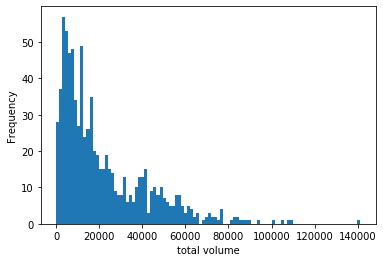

In [17]:
# Let's plot a histogram of the 'total volume'

plt.hist(x=volume['total volume'],bins=100);
plt.xlabel('total volume')
plt.ylabel('Frequency')

In [18]:
# Apply the "Station Volume Mapping Function" to the full dataset to see the where highest and lowest volume stations are
# located geographically. 

# The 'total volume' percentile for each station is indciated as follows:  
# -The 25th percentile stations are plotted as red circles.
# -The stations bounded by the 25th to 75th percentile are plotted as yellow circles.
# -The stations above the 75th percentile (top 25 stations for 'total volume') are plotted as blue circles.

# Comments on the plot:

# The blue circles are located primarily in Midtown Manhattan and Lower Manhattan. There are 8 blue circles in the Upper
# West Side and 6 blue circles Upper East side. There are no blue circles in Queen's and only 9 blue circles in Brooklyn.

# There are less than 30 red circles on all of Manhattan Island and they are primarily concentrated in Harlem and East Harlem.
# The majority of all circles present in Queens are red circles. In Brooklyn, there are clusters of red circles representing 
# the bike stations furthest from Manhattan.

# There are only 18 yellow circles in Queen's. Brooklyn is largely comprised of yellow circles. The regions of Manhattan above
# Midtown Manhattan are largely comprised of yellow circles. There is a cluster of yellow circles in the east side of
# Midtown manhattan and along the south coast of Lower Manhattan.

volumemap=stationvolumemap(volume,dataset,"DS1-ALLstations.html")
os.system('DS1-ALLstations.html')

0

In [19]:
# Apply the "Station Volume Mapping Function" to the "top 10% of stations" to see the where highest and lowest volume stations are
# located geographically. 

# The 'total volume' percentile for each station is indciated as follows:  
# -The 25th percentile stations are plotted as red circles.
# -The stations bounded by the 25th to 75th percentile are plotted as yellow circles.
# -The stations above the 75th percentile (top 25 stations for 'total volume') are plotted as blue circles.

# Comments on the plot:
# All of these points are in Lower or Midtown Manhattan except for one in the Upper East Side and one in the Uppwer West Side.
# There are no trends with regard to color and location.

volumeMOD=volume[volume['total volume']>=51341.2]
volumemap=stationvolumemap(volumeMOD,dataset,"DS1-TOP10Pstations.html")
os.system('DS1-TOP10Pstations.html')

0

In [20]:
##############################################################################################################################

In [21]:
# Data Story 2 - How frequently was each trip taken? Where did the most frequently taken trips start and end?

In [22]:
# Apply the "Trip Frequency Analysis Function" to the full dataset to calculate the number of times each trip
# was taken.

freqanalysis=tripfreq(dataset)

In [23]:
# Print out shows the 5 trips with the highest 'frequency'. 

freqanalysis.head()

,trip,frequency
0,432.0 to 3263.0,4040
1,2006.0 to 3282.0,2624
2,519.0 to 492.0,2592
3,2006.0 to 2006.0,2499
4,3093.0 to 460.0,2378


In [24]:
# The total number of unique trips taken is 304,919 over the six month time frame. 

# Minimum 'frequency' is 1 and Maximum 'frequency' is 4040.
# Median 'frequency' is 5 and Mean 'frequency' is 29.

# 25% of the trips (~76,230 trips) were taken only 1 or 2 times.
# 50% of the trips (~152,460 trips) were taken anywhere from 3 to 22 times.
# 25% of the trips (~76230 trips) were taken 23 or more times.

freqanalysis['frequency'].describe()

count    304919.000000
mean         29.379347
std          78.722358
min           1.000000
25%           2.000000
50%           5.000000
75%          22.000000
max        4040.000000
Name: frequency, dtype: float64

In [25]:
# let's examine percentile values from 80% to 99.9%

# The top 1% of trips for 'frequency' (3049 trips) were taken more than 354 times.
# The top 0.1% of trips for 'frequency' (305 trips) were taken more than 935 times.

x=[.80,.85,.90,.95,.96,.97,.98,.99,.995,0.999]
f=[0,0,0,0,0,0,0,0,0,0]

for i,j in enumerate(x):
    f[i] = freqanalysis['frequency'].quantile(j)
    print(x[i]*100,'%:', f[i])

80.0 %: 31.0
85.0 %: 46.0
90.0 %: 74.0
95.0 %: 137.0
96.0 %: 161.0
97.0 %: 194.0
98.0 %: 247.0
99.0 %: 354.0
99.5 %: 481.0
99.9 %: 935.1640000001062


In [26]:
# Apply "Trip Frequency Mapping Function" to plot the top 305 trips (Top 0.1%). Each of these trips was taken in excess of 935
# times.

# For the trips being plotted:
# -Stations that are only start stations are plotted as pink circles.
# -Stations that are only end stations are plotted as cyan circles
# -Stations that are both end stations and start stations are plotted as purple circles.
# -A blue line is drawn from the start station to the end station to show where a trip begins and ends. 

# Comments on the plot:
# The majority of these trips are inside of Manhattan. There are a large number of trips within Midtown Manhattan and the East 
# Village Region of Lower Manhattan. There are many trips inside of Central Park and along the waterfront from Battery Park to
# as far north as the Hudson Yards.The trips in Brooklyn tend to appear in isolated clusters.

durplot=tripfreqmap(freqanalysis, dataset,935,'DS2-top305trips.html')
os.system('DS2-top305trips.html')

0

In [27]:
#############################################################################################################################

In [28]:
# Data Story 3 - What do data story one and data story two look like when comparing 'usertype' (customer vs. subscriber)?

# Create two data sets. One data set for annual members (subscribers). 
# One data set for 24-hour and 3-day pass holders (customers).

anndata=dataset[dataset['usertype']=='Subscriber'].copy()
passdata=dataset[dataset['usertype']=='Customer'].copy()

In [29]:
# 88% of the trips were taken by subscribers and 12% of the trips were taken by customers. 

dataset['usertype'].value_counts()

Subscriber    7926815
Customer      1031506
Name: usertype, dtype: int64

In [30]:
# Apply the "Station Volume Analysis Function" to the subscriber dataset to calculate the 'total volume' (trip starts + trip stops)
# for each of the stations used by subscribers.

avolume=stationvolume(anndata)

In [31]:
# Print out shows the 10 stations with the highest subscriber 'total volume'. 

avolume.head(10)

,station id,ss volume,es volume,total volume
0,519.0,66131,66437,132568
1,402.0,49493,53234,102727
2,3255.0,50210,50651,100861
3,497.0,48589,49316,97905
4,285.0,46599,47510,94109
5,435.0,42688,42890,85578
6,490.0,38611,38818,77429
7,293.0,38092,39289,77381
8,358.0,38298,38285,76583
9,459.0,37467,37940,75407


In [32]:
# Apply the "Station Volume Analysis Function" to the customer dataset to calculate the 'total volume' (trip starts + trip stops)
# for each of the stations used by customers.

pvolume=stationvolume(passdata)

In [33]:
# Print out shows the 10 stations with the highest customer 'total volume'. 

pvolume.head(10)

,station id,ss volume,es volume,total volume
0,2006.0,14752,12148,26900
1,3282.0,12017,14072,26089
2,514.0,11402,11720,23122
3,387.0,10078,11146,21224
4,3137.0,10078,11090,21168
5,3165.0,9548,10535,20083
6,426.0,9176,10224,19400
7,281.0,11065,7657,18722
8,3256.0,9565,9128,18693
9,3724.0,8028,9044,17072


In [34]:
# From observation of the two print outs above, the top ten stations for total volume for customers and the top ten stations
# subscribers for total volume of subscribers do not have a single station in common.

In [35]:
# We compare the top 100 subscriber stations to the top 100 customer stations and see that there are only 42 stations in common
# which is only 42% match.

aa=avolume.head(100)
pp=pvolume.head(100)
cc=aa[aa['station id'].isin(pp['station id'])==True]
cc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 0 to 98
Data columns (total 4 columns):
station id      42 non-null float64
ss volume       42 non-null int64
es volume       42 non-null int64
total volume    42 non-null int64
dtypes: float64(1), int64(3)
memory usage: 1.6 KB


In [36]:
# Apply the "Station Volume Comparison Mapping Function" to plot the top 100 'total Volume' stations for customers and the
# top 100 'total Volume' stations for subscribers.  

# The "subscriber only" stations are plotted as sky blue circles.
# The "customer only" stations are plotted as magenta circles.
# The stations common to both subscribers and customers are plotted as orange circles.

# Comments on Plot:
# Blue circles are concentrated primarily in Lower Manhattan and Midtown Manhattan.
# In Manhattan, pink Circles are located primarily along the boundaries of Cental Park and along the Hudson River.
# In Brooklyn, pink cirlces are located hear the Brooklyn bridge and in Williamsburg.
# The orange circles for "common stations" are located primarily in Lower Manhattan and Midtown Manhattan.

CScompare= passannvolumemap(avolume,pvolume,42425,5064, dataset,'DS3-CScompare.html')
os.system('DS3-CScompare.html')

0

In [37]:
# Apply the "Trip Frequency Analysis Function" to the subscriber dataset to calculate the number of times each subscriber trip
# was taken.

afreqanalysis=tripfreq(anndata)

In [38]:
# Print out shows the 5 subscriber trips with the highest 'frequency'. 

afreqanalysis.head(5)

,trip,frequency
0,432.0 to 3263.0,3953
1,519.0 to 492.0,2511
2,3664.0 to 327.0,2312
3,3093.0 to 460.0,2264
4,3118.0 to 3119.0,2119


In [39]:
# Apply the "Trip Frequency Analysis Function" to the customer dataset to calculate the number of times each customer trip
# was taken.

pfreqanalysis=tripfreq(passdata)

In [40]:
# Print out shows the 5 customer trips with the highest 'frequency'. 

pfreqanalysis.head(5)

,trip,frequency
0,2006.0 to 3282.0,2295
1,2006.0 to 2006.0,1817
2,281.0 to 3282.0,1387
3,387.0 to 387.0,1306
4,3423.0 to 3423.0,1290


In [41]:
# Apply "Trip Frequency Mapping Function" to plot the top 200 subscriber trips. Each of these trips was taken in excess of 967
# times.

#Comments on Plot:
#The majority of these trips are inside of Manhattan. There are a large number of trips within Midtown Manhattan and the East 
# Village Region of Lower Manhattan. There are small clusters of trips in Brooklyn.

afreqplot=tripfreqmap(afreqanalysis, anndata,967,'DS3-Stop200Trips.html')
os.system('DS3-Stop200Trips.html')

0

In [42]:
# Apply "Trip Frequency Mapping Function" to plot the top 200 customer trips. Each of these trips was taken in excess of 258
# times.

# Comments on Plot:
# The majority of the trips are trips accross the Brooklyn Bridge,inside of Central Park and along the waterfront from Battery Park to
# as far north as the Hudson Yards. There are no trips Lower Manhattan or the Midtown Manhattan. 

pfreqplot=tripfreqmap(pfreqanalysis, passdata,258,'DS3-Ctop200trips.html')  
os.system('DS3-Ctop200trips.html')

0

In [43]:
# It appears that the customers are taking recreational trips in areas that are popular with tourists while the subscribers are
# taking trips within Lower Manhattan or the Midtown Manhattan which are likely more pragmatic in nature as these trips are not
# so common with the customers who have 24 hour or 3 day passes.

In [44]:
#############################################################################################################################

In [45]:
# Data Story 4 - What do data story one and data story two look like when comparing 'gender' ( Male vs. Female)?

# Create two data sets. One data set for Male and one for Female. 

Mdata = dataset[dataset['gender']==1].copy()
Fdata = dataset[dataset['gender']==2].copy()

In [46]:
# 70% of the trips were taken by males and 23% of the trips were taken by females. 
# The gender of the rider is 'unknown' for the remaining 7% of the trips.

dataset['gender'].value_counts()

1    6264533
2    2079228
0     614560
Name: gender, dtype: int64

In [47]:
# 94% of the male trips taken by subscribers and 6% of the male trips were taken by customers. 

Mdata['usertype'].value_counts()

Subscriber    5901493
Customer       363040
Name: usertype, dtype: int64

In [48]:
# 90.5% of the female trips taken by subscribers and 9.5% of the female trips were taken by customers. 

Fdata['usertype'].value_counts()

Subscriber    1881309
Customer       197919
Name: usertype, dtype: int64

In [49]:
# Apply the "Station Volume Analysis Function" to the male dataset to calculate the 'total volume' (trip starts + trip stops)
# for each of the stations used by males.

Mvolume=stationvolume(Mdata)

In [50]:
# Print out shows the 10 stations with the highest male 'total volume'. 

Mvolume.head(10)

,station id,ss volume,es volume,total volume
0,519.0,59067,59811,118878
1,3255.0,45150,44932,90082
2,402.0,39620,41905,81525
3,497.0,37864,37610,75474
4,285.0,36733,37050,73783
5,490.0,34509,34919,69428
6,477.0,33255,34271,67526
7,492.0,33266,34202,67468
8,359.0,32770,33068,65838
9,435.0,32400,32243,64643


In [51]:
# Apply the "Station Volume Analysis Function" to the female dataset to calculate the 'total volume' (trip starts + trip stops)
# for each of the stations used by females.

Fvolume=stationvolume(Fdata)

In [52]:
# Print out shows the 10 stations with the highest female 'total volume'. 

Fvolume.head(10)

,station id,ss volume,es volume,total volume
0,426.0,12272,13103,25375
1,497.0,12050,13107,25157
2,402.0,11087,12548,23635
3,285.0,11170,11549,22719
4,435.0,10860,11165,22025
5,514.0,10239,10372,20611
6,459.0,9826,10184,20010
7,3435.0,9966,9866,19832
8,358.0,9841,9954,19795
9,499.0,10092,9666,19758


In [53]:
# From observation of the two print outs above, the top ten stations for total volume for males and female only have
# four stations in common.

In [54]:
# We compare the top 100 male stations to the top 100 female stations and see that there are only 42 stations in common
# which is a 76% match.

MM=Mvolume.head(100)
FF=Fvolume.head(100)
MMFF=MM[MM['station id'].isin(FF['station id'])==True]
MMFF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76 entries, 0 to 99
Data columns (total 4 columns):
station id      76 non-null float64
ss volume       76 non-null int64
es volume       76 non-null int64
total volume    76 non-null int64
dtypes: float64(1), int64(3)
memory usage: 3.0 KB


In [55]:
# Apply the "Station Volume Comparison Mapping Function" to plot the top 100 'total Volume' stations for Males and the
# top 100 'total Volume' stations for Females. Although this function was designed for comparing customers and subscribers, it
# works for Male and Female comparisons.

# The Male stations are plotted as sky blue circles.
# The Female stations are plotted as magenta circles.
# The stations common to both subscribers and customers are plotted as orange circles.

# Comments on the plot:
# Magenta circles are found in the Upper West Side and Upper East Side near Central Park, in Williamsburg and in Lower Manhattan.
# Blue circles are found primarily in Midtown Manhattan.
# Orange circles are found in Midtown Manhattan and Lower Manhattan.

MFcompare= passannvolumemap(Mvolume,Fvolume,34707,10822, dataset,'DS4-MFcompare.html')
os.system('DS4-MFcompare.html')

0

In [56]:
# Apply the "Trip Frequency Analysis Function" to the male dataset to calculate the number of times each male trip
# was taken.

Mfreqanalysis=tripfreq(Mdata)

In [57]:
# Print out shows the 5 male trips with the highest 'frequency'.

Mfreqanalysis.head()

,trip,frequency
0,432.0 to 3263.0,2864
1,519.0 to 492.0,2375
2,3664.0 to 327.0,2254
3,327.0 to 3664.0,2031
4,519.0 to 491.0,1873


In [58]:
# Apply the "Trip Frequency Analysis Function" to the female dataset to calculate the number of times each female trip
# was taken.

Ffreqanalysis=tripfreq(Fdata)

In [59]:
# Print out shows the 5 female trips with the highest 'frequency'.

Ffreqanalysis.head()

,trip,frequency
0,432.0 to 3263.0,1126
1,317.0 to 3263.0,673
2,258.0 to 324.0,672
3,502.0 to 307.0,664
4,3423.0 to 3423.0,625


In [60]:
# Apply "Trip Frequency Mapping Function" to plot the top 200 Male trips. Each of these trips was taken in excess of 799
# times.

#Comments on plot:
# The majority of these trips are inside of Manhattan. There are a large number of trips within Midtown Manhattan and the East 
# Village Region of Lower Manhattan. There are small clusters of trips in Brooklyn. Thereis a cluster of trips around the Battery
# Park Area and another cluster in Tribeca.

Mdurplot=tripfreqmap(Mfreqanalysis, Mdata,799,'DS4-Mtop200trips.html')
os.system('DS4-Mtop200trips.html')

0

In [61]:
# Apply "Trip Frequency Mapping Function" to plot the top 200 female trips. Each of these trips was taken in excess of 256
# times.

#Comments on plot:
# There appear to me more distinct clusters in the female trip plot than the male plot. The female clusters of trips include:
# inside of Central Park, the waterfront from Battery Park to Hudson Yards, the East Village and Williamsburg. The female trips
# do not occur in MiDtown Manhattan the way the male trips do.

Fdurplot=tripfreqmap(Ffreqanalysis, Fdata,256,'DS4-Ftop200trips.html')
os.system('DS4-Ftop200trips.html')

0

In [62]:
# Despite both the male data set and female data set being comprised of greater than 90% subscribers, the male top 200 trips 
# appears to closely resemble the top 200 subscriber trips while the top 200 female trips shows some resemblence to the top 200 
# customer trips, particularly the central park trips and waterfront trips from Battery park to Hudson Yards.

In [63]:
##############################################################################################################################

In [64]:
# Data Story 5 - Where these stations available for use during the entire six month time frame?

In [65]:
# We will assume that if a station has no "trip starts" or "trip stops" on a given day that the station was not 
# available for service on that day.  

# a data frame with 'station id' as the index and each day of the six month period  as the columns has been created.
# the columns are assigned 0 or 1 to indicate whether or not a trip stop or trip start occurred on that day.

duration=dataset[['start station id','starttime']].copy()
duration.columns=['station', 'day']

addendstation=dataset[['end station id','stoptime']].copy()
addendstation.columns=['station','day']

duration=duration.append(addendstation,ignore_index=True,sort=False)
duration['day']=duration['day'].dt.date

duration=duration.groupby('station')['day'].value_counts()
duration=pd.DataFrame(duration)
duration.sort_index(level=['station','day'],ascending=[True,True],inplace=True)
duration.columns=['volume']

duration=duration.unstack(level=-1)

duration=duration.fillna(0)
duration[duration != 0] = 1

duration.head()

volume                                                         \
day     2019-01-01 2019-01-02 2019-01-03 2019-01-04 2019-01-05 2019-01-06   
station                                                                     
72.0           1.0        1.0        1.0        1.0        1.0        1.0   
79.0           1.0        1.0        1.0        1.0        1.0        1.0   
82.0           1.0        1.0        1.0        1.0        1.0        1.0   
83.0           0.0        0.0        1.0        1.0        1.0        1.0   
116.0          0.0        0.0        0.0        0.0        0.0        0.0   

                                                     ...             \
day     2019-01-07 2019-01-08 2019-01-09 2019-01-10  ... 2019-06-21   
station                                              ...              
72.0           1.0        1.0        1.0        1.0  ...        1.0   
79.0           1.0        1.0        1.0        1.0  ...        1.0   
82.0           1.0        1.0        1.0        1.0  ...        1.0   
83.0           1.0        1.0        1.0        1.0  ...        1.0   
116.0          0.0        0.0        0.0        0.0  ...        1.0   

                                                                           \
day     2019-06-22 2019-06-23 2019-06-24 2019-06-25 2019-06-26 2019-06-27   
station                                                                     
72.0           1.0        1.0        1.0        1.0        1.0        1.0   
79.0           1.0        1.0        1.0        1.0        1.0        1.0   
82.0           1.0        1.0        1.0        1.0        1.0        1.0   
83.0           1.0        1.0        1.0        1.0        1.0        1.0   
116.0          1.0        1.0        1.0        1.0        1.0        1.0   

                                          
day     2019-06-28 2019-06-29 2019-06-30  
station                                   
72.0           1.0        1.0        1.0  
79.0           1.0        1.0        1.0  
82.0           1.0        1.0        1.0  
83.0           1.0        1.0        1.0  
116.0          1.0        1.0        1.0  

[5 rows x 181 columns]

In [66]:
# The 0 and 1 values are summed to get availability totals for each of the six months.
# The availability totals are subtracted from the total days in each month to get unavailability totals.
# A data frame of the stations with perfect availablity is generated.
# A data frame of the stations with one or more days of unavailability is generated.

duration['jan']= duration.iloc[:,0:31].sum(axis=1)      # 31 days in Jan.
duration['feb']= duration.iloc[:,31:59].sum(axis=1)     # 28 days in Feb.
duration['mar']= duration.iloc[:,59:90].sum(axis=1)     # 31 days in Mar.
duration['apr']= duration.iloc[:,90:120].sum(axis=1)    # 30 days in Apr.
duration['may']= duration.iloc[:,120:151].sum(axis=1)   # 31 days in May.
duration['jun']= duration.iloc[:,151:181].sum(axis=1)   # 30 days in Jun.
duration['total']= duration.iloc[:,0:181].sum(axis=1)   # 181 operating days in 6 months being analyzed.
duration['unavailable']= 181 - duration['total']        # Number of days that station is NOT operated, i.e. 'unavailable'.

summary=duration[['jan','feb','mar','apr','may','jun','total','unavailable']].copy()

available=summary[summary['unavailable']==0].copy()
available.drop('unavailable',axis=1,inplace=True)

unavailable=summary[summary['unavailable']!=0].copy()

unavailable['jan']=31-unavailable['jan']
unavailable['feb']=28-unavailable['feb']
unavailable['mar']=31-unavailable['mar']
unavailable['apr']=30-unavailable['apr']
unavailable['may']=31-unavailable['may']
unavailable['jun']=30-unavailable['jun']
unavailable.drop('total',axis=1,inplace=True)
unavailable=unavailable.sort_values('unavailable', ascending=False)

In [67]:
unavailable.head()

,jan,feb,mar,apr,may,jun,unavailable
day,,,,,,,
station,,,,,,,
5555.0,28.0,28.0,31.0,30.0,31.0,30.0,178.0
3719.0,28.0,28.0,31.0,30.0,31.0,30.0,178.0
489.0,31.0,28.0,31.0,30.0,31.0,27.0,178.0
3250.0,28.0,28.0,30.0,30.0,31.0,30.0,177.0
3153.0,20.0,28.0,31.0,30.0,31.0,30.0,170.0


In [68]:
# 620 out of 822 stations (75%) are available every day during the six month time frame.

available.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 620 entries, 72.0 to 3721.0
Data columns (total 7 columns):
(jan, )      620 non-null float64
(feb, )      620 non-null float64
(mar, )      620 non-null float64
(apr, )      620 non-null float64
(may, )      620 non-null float64
(jun, )      620 non-null float64
(total, )    620 non-null float64
dtypes: float64(7)
memory usage: 38.8 KB


In [69]:
# 202 out of 822 stations (25%) have at least one day of with no trip starts or trip stops. This will be interpretted as a day
# unavailability.

unavailable.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 202 entries, 5555.0 to 3540.0
Data columns (total 7 columns):
(jan, )            202 non-null float64
(feb, )            202 non-null float64
(mar, )            202 non-null float64
(apr, )            202 non-null float64
(may, )            202 non-null float64
(jun, )            202 non-null float64
(unavailable, )    202 non-null float64
dtypes: float64(7)
memory usage: 12.6 KB


In [70]:
# For the stations that have at least one day of unavailability:

# The mean unavailability is 50.28 days and median unavailability is 19.50 days.
# Thus, 101 stations have unavailability of 19.50 days or less out of 181 operating days.
# So these 101 stations are unavailable less than 10% of the time (greater than 90% availability).

# The 75th percentile is 107 days.
# Thus, ~50 stations have unavailability of greater than 19.50 days but less than or equal to 107 days.
# So these ~50 stations are unavailable between 10% and 59% of the time. (41% to 90% availability)

# The remaining ~50 stations have unavailability greater than 107 days but less than or equal to 178 days.
# So these stations are unavailable between 59% and 98% of the time. (2% to 41% availability)

unavailable['unavailable'].describe()

count    202.000000
mean      50.282178
std       57.487135
min        1.000000
25%        2.000000
50%       19.500000
75%      107.000000
max      178.000000
Name: unavailable, dtype: float64

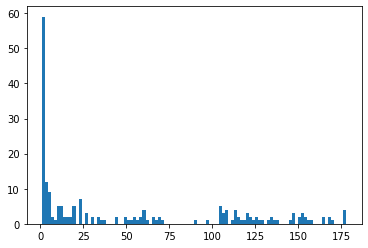

In [71]:
# Lets plot a histogram

plt.hist(x=unavailable['unavailable'],bins=100);

In [72]:
# Apply the Availability Mapping Function to map the stations and color-code them based on availability as follows:
# -The stations 100% availablity are plotted as blue circles.
# -The stations in the 50th percentile of unavailability (>90% availability) are plotted as cyan circles.
# -The stations bounded by the 50th to 75th percentile of unavailability (41% to 90% availability) are plotted as yellow circles.
# -The stations above the 75th percentile of unavailability (2% to 41% availability) are plotted as red circles.

# Comments on plot:
# There is a cluster of red and yellow in the East Williamsburg area. This area is on the edge of the Citibike service area.
# There is a cluster of cyan with a few red and yellow circles in close proximity on the lower end of Midtown Manhattan. However,
# cyan stations are available over 90% of the time.
# Aside from the two clusters, almost all cyan, red, yellow circles have adjacent circles that are blue.

# Based on the observations made here, station unavailability is unlikely to impact most users as stations which were available
# throughout the six months are usually adjacent the stations which had unavailability. 

# It should be noted that "no trip starts or trip stops on a given day" is not a perfect measure of unavailability. It could be
# the case that there were actually no trip starts or trip stops. The plot generated for this data story shows the three stations
# on Governors Island as red. It is suspected that very few people are taking the ferry there to go cycling in January or 
# February. The trips on Governors Island are popular and appeared on several of the other plots.
 

unavailabilitymap(available,unavailable,dataset,'DS5-unavail.html')
os.system('DS5-unavail.html')

0

In [73]:
##############################################################################################################################